James Oswald  
ISCI-6962  
Final Report  

The full code along with this notebook can be found on github at: https://github.com/James-Oswald/Logic-Masking-RL

# Speeding Up Deep Reinforcement Learning Agents in Dynamic Grid Worlds via Reasoning

#### Abstract
We investigate an alignment problem focussed on aligning a DQN based reinforcement learning model’s output with our desired illegal actions that should never be performed. We benchmark our task on the minigrid dynamic object environment, which offers sparse positive rewards, thus making it a harder task for DQN. We measure our success based off two metrics, the average reward per test cycle after training and the amount of illegal actions performed which measures how well our model has become aligned with our constraints. We test out four methods: 1) a baseline in which nothing is done for illegal actions, 2) a model that masks illegal actions for exploration and thresholds greedy illegal actions, 3) a model that assigns a strong negative penalty for illegal actions, 4) a model that both masks/thresholds and then assigns a penalty for any that made it through. We find that all of the methods work much better than the baseline at limiting illegal actions in this environment, with a performance tradeoff. 

### Introduction
Machine learning and by extension reinforcement learning making use of machine learning methods are inherently unsafe from an alignment perspective. Unlike deterministic algorithms which are easy to formally verify the behavior of, there is often no way to verify the behavior of a model unless its output is checked against every possible input which is computationally infeasible. Beyond this, due to training data almost never being truly sufficient, it is easy in many models to create adversarial examples which can be used to explicitly attempt to get a desired, potentially malicious output (\[Eykholt et al. 2017\])[https://arxiv.org/abs/1707.08945]. In reinforcement learning, DQNs and other ML based RL approaches in particular, adversarial state observations could be provided to get targeted malicious behavior from the agent if not careful. Even discounting the case of an adversarial attack, there is always a non-zero chance that the model ends up in an out of sample state and performs an unexpected and undesired action. In simulations this is typically fine, but when using RL agents in real life where actions have real consequences, some actions in some situations are completely off limits. An example of which might be a self-driving car, driving forward is permissible in almost all states, but if we enter a state with a human in front of us we want to explicitly forbid the car from driving forward \[Footnote 1\].  We will refer to these actions as “state dependent illegal actions”, or just as “illegal actions” for short, keeping in mind that they depend on the state. 

In an ideal situation, we can simply use the policy and discard any illegal actions by selecting the next best one. This however neglects the ideal of alignment. Beyond just guaranteeing that our agent never performs illegal actions in training, we want to ensure that the agent’s policy reflects this will, having the policy be less likely to suggest illegal actions. We investigate two approaches to this problem. The first being masking and thresholding illegal actions during training, the second being dynamically penalizing illegal actions. 

\[Footnote 1\] Inherently, this interpretation adds a symbolic level to the state observations we are working with as we have to take for granted that we would know if a human was in front of us, if we simply rely on another ML model for this task, we become stuck in a bit of a catch 22 due in that we can no longer formally ensure that we never see a human. For the sake of this work, we assume we have true uncompromised knowledge of the world to reason with, which we refer to as the symbolic omnipotence assumption.   


### Related work:

There is a small body of literature that focuses on the illegal action alignment problem, in different forms and going by different names, however most of them deal under a non-symbolic omnipotence assumption like we do (we always know the true symbolic state of the world), instead trying to learn which actions should be illegal. The first is [Matthieu et al. 2020](https://arxiv.org/pdf/1910.02078.pdf) which uses DQN and adds an additional term to the loss function to deal with illegal actions. This approach inheritance conflicts with the symbolic omnipotence approach we are taking by attempting to classify individual action constraint violation, rather than using true constraints. The idea for action masking and thresholding training  came from a simplified combination of  [Even-Dar et al. 2006](https://jmlr.org/papers/volume7/evendar06a/evendar06a.pdf), [Zahavy et al. 2008](https://arxiv.org/pdf/1809.02121.pdf) which remove invalid actions outside of a confidence interval (in our case a threshold) and [Alshiekh et al. 2017](https://arxiv.org/pdf/1708.08611.pdf) who introduces shielding, a more advanced version of masking. 

### Dataset
For my dataset I selected the [minigrid gymnasium environment](https://github.com/Farama-Foundation/MiniGrid). Minigrid is a 2d gridworld in which an agent moves around in a room trying to get to a goal before the agent runs out of time. Minigrid provides a number of environments to us that provide additional difficulty such as moving obstacles, locked doors and keys, and lava pits, all of which impact our rewards. Here is an example of minigrid in action

![](https://minigrid.farama.org/_images/EmptyEnv.gif)

Of particular interest to this work is the dynamic obstacle environment which has moving obstacles which kill the agent when they touch it. This environment requires both the ability to path find as well as the ability to stay away from the dangerous objects. Due to the randomly moving nature of the objects it is important to give them a wide berth.


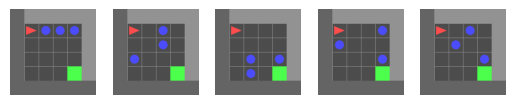

In [131]:
import minigrid
from minigrid.wrappers import FullyObsWrapper
import gymnasium as gym
import matplotlib.pyplot as plt

steps = 5

fig, ax = plt.subplots(1, steps)
env = FullyObsWrapper(gym.make("MiniGrid-Dynamic-Obstacles-6x6-v0", render_mode="rgb_array")) 
for i in range(steps):
    observation, _ = env.reset()
    img = env.render()
    ax[i].axis("off")
    ax[i].imshow(img)


The environment is represented as a MDP using the gymnasium API, The action space of this environment is discrete, the agent can either turn left, turn right, or move forward. The observation space is 
1) a 6x6x3 "image" where 6x6 is the size of the environment, the 3 is for the 3 properties of each grid square, the ID of the object, the color, and the state 
2) a direction value which corresponds to which direction the agent is facing.
3) a mission statement which just lists what the task is, we discard this. 

We can observe these as follows:

In [251]:
print(env.action_space)
print(env.observation_space)

Discrete(3)
Dict('direction': Discrete(4), 'image': Box(0, 255, (6, 6, 3), uint8), 'mission': MissionSpace(<function DynamicObstaclesEnv._gen_mission at 0x0000018E6A0DEAF0>, None))


### Model
For our model we select a Deep Q Network (DQN) [Minh et al. 2013](https://arxiv.org/abs/1312.5602) which is an off policy model free RL algorithm. DQN works by storing state x next_state x pair x reward transitions while learning in memory which can be randomly sampled to reduce time dependance. A policy network tries its best to estimate Q while the target network tries to estimate the expected Qs. The temporal difference loss is then used between the estimated Qs and the expected Qs to get how different they are, this is used to update the policy network which has its parameters copied over to the target network every tau turns. For selecting exploration vs exploitation we use Epsilon greedy decay in which the threshold for selecting a random action decreases exponentially to a minimum value over the number of episodes. Our epsilon greedy rate can be seen in:

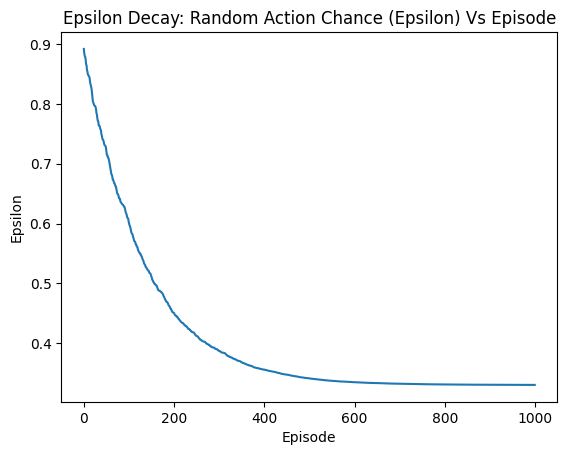

In [254]:
from IPython.display import Image
Image(filename='epsilon.png')


### Implementation

The following block is broken into 3 parts
1) Base classes required for DQN
  * The Replay Memory
  * The DQN network 
  * The observationToTensor function which converts our inputs
2) Hyperparameters 
3) Illegal actions
 * Environment specific dicts which outline what the rules mean.
 * A list of illegal actions
 * A method that converts an observation into an action mask based on the illegal action rules.


In [242]:
import math 
import random
from collections import namedtuple, deque

#RL Libs
import torch                #Main ML lib
import gymnasium as gym     #RL environment

#Yea CUDA lets go FAST
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")

#Converts a minigrid observation (state) to a torch tensor used as input to the model.
#Encodes the image and a one hot encoding of the direction the agent is facing
def observationToTensor(env, observation):
    directionTensor = torch.tensor(observation["direction"], device=device)
    directionOHE = torch.nn.functional.one_hot(directionTensor, num_classes=env.observation_space["direction"].n)
    flatImage = torch.flatten(torch.tensor(observation["image"], device=device))
    return torch.cat([directionOHE, flatImage]).type(torch.float)
    #return flatImage.type(torch.float)

Transition = namedtuple('Transition', ('observationTensor', 'action', 'nextObservationTensor', 'reward'))

class ReplayMemory:
    def __init__(self, size):
        self.memory = deque(maxlen=size)

    def __len__(self):
        return len(self.memory)
        
    def append(self, observationTensor, action, nextObservationTensor, reward):
        self.memory.append(Transition(observationTensor, action, nextObservationTensor, reward))

    def sample(self, size):
        return random.sample(self.memory, size)

class MinigridDQN(torch.nn.Module):
    '''
        Computes Q values for all actions, returning an array
        [Q(s, action1), Q(s, action2), Q(s, action3)]
    '''

    def __init__(self, env:gym.Env, hiddenSizes:"list[int]" = [100, 100, 50]) -> None:
        super(MinigridDQN, self).__init__()
        self.directionShape = env.observation_space["direction"].n       #Number of directions (flattened into a one hot encoding)
        self.viewShape = math.prod(env.observation_space["image"].shape)      #Number of items in observation space
        inputShape = self.directionShape + self.viewShape                #Combined Direction + Image Input Tensor size
        #inputShape = self.viewShape 
        outputShape = env.action_space.n                                 #The Number of actions
        
        #Layers
        self.hiddenLayers = torch.nn.ModuleList()
        inputCatHiddenSizes = [inputShape] + hiddenSizes
        for i in range(1, len(inputCatHiddenSizes)):
            self.hiddenLayers.append(torch.nn.Linear(inputCatHiddenSizes[i-1], inputCatHiddenSizes[i]))
        self.outputLayer = torch.nn.Linear(hiddenSizes[-1], outputShape)
    
    def forward(self, x):
        for layer in self.hiddenLayers:
            x = torch.relu(layer(x))
        x = self.outputLayer(x)
        return x

#Libs for the agent
import math
import random
import minigrid
from minigrid.wrappers import FullyObsWrapper, StateBonus
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.optim as optim

#Hyperparameters
numTestEps = 50 #Number of episodes to test for
epsBetweenTests = 25 #number of episodes to run before a test
printUpdateEpisodes = 100
num_episodes = 1000   # Number of episodes
BATCH_SIZE = 256      # Number of experiences to train on
MEMORY_SIZE = 60000    # Size of the replay memory
GAMMA = 0.999         # Discount in (0, 1): 0 -> Prioritize short term rewards, 1 -> Prioritize Long Term

#Should ideally be pretty big
TARGET_UPDATE = 1200    # Number of optimization steps before updating the target net

#epsilon greedy policy Hyperparameters
EPS_START = 0.9     # Starting epsilon (random action chance)
EPS_END = 0.33      # Ending epsilon (random action chance)
EPS_DECAY = 1000     # Rate at which epsilon decays during training

optimizerType = optim.Adam #Type of optimizer
lossFunc = torch.nn.SmoothL1Loss()

env = FullyObsWrapper(gym.make("MiniGrid-Dynamic-Obstacles-Random-6x6-v0", max_steps=15))    #Environment 

#Rule Logic
directionForward = {
    0: np.array([0, +1]),
    1: np.array([+1, 0]),
    2: np.array([0, -1]), 
    3: np.array([-1, 0])
}

TileDict = {
    2 : "wall",
    10 : "agent",
    1 : "space",
    6 : "obstacle",
    8 : "goal"
}

ActionDict = {
    0: "left",
    1: "right",
    2: "forward"
}

rules = [
    ("goal", "left"),
    ("goal", "right"),
    ("wall", "forward")
]

#Create a mask of what an agent is or isn't allowed to do based off the observation and rules
def ruleMask(observation, illegal=-1):
    grid = observation["image"][:,:,0]
    direction = directionForward[observation["direction"]]
    agentPos = np.array(list(zip(*np.where(grid == 10)))[0])
    tilePos = agentPos + direction
    tile = grid[tilePos[0], tilePos[1]]
    actionMask = []
    for action in range(env.action_space.n):
        actionMask.append(illegal if (TileDict[tile], ActionDict[action]) in rules else 1)
    return np.array(actionMask, dtype=np.int8)


[ 1  1 -1]


We test our rules on a fake board to enure we get the correct action mask

In [252]:
#A fake board observation to test our item
fakeObs = {
    "direction": 0,
    "image": np.array(
      [[ [2],  [2],  [2],  [2],  [2],  [2]],
       [ [2],  [1],  [6],  [1], [10],  [2]],
       [ [2],  [1],  [6],  [1],  [1],  [2]],
       [ [2],  [1],  [1],  [6],  [1],  [2]],
       [ [2],  [1],  [1],  [1],  [8],  [2]],
       [ [2],  [2],  [2],  [2],  [2],  [2]]], dtype=np.uint8)
}

print(ruleMask(fakeObs))

[ 1  1 -1]


#### Metrics and Evaluation

We evaluate our experiments in two key ways 1) Average reward per test cycle and 2) Average illegal actions per test cycle. Ideally we would like reward on the higher side as this means we are performing well on the task and the number of illegal actions to be lower since this means that we are aligning well to our constraints. In this context a "test cycle" is a cycle we perform every `epsBetweenTests` episodes. Each testing cycle we perform `numTestEps` testing episodes where we evaluate a pure greedy policy on the environment. We average the reward and illegal actions taken on a per test cycle basis which is reported every `epsBetweenTests` episodes. 


#### Experiment 1: Baseline DQN

In this model we implement a base DQN in pytorch for the minigrid dynamic obstacles environment. This model will serve as a baseline to compare against our other models that modify the training process in an attempt to get lower illegal actions.

In [228]:

memory = ReplayMemory(MEMORY_SIZE)
policy_net = MinigridDQN(env).to(device)    #Agent Policy Net
target_net = MinigridDQN(env).to(device)    
target_net.load_state_dict(policy_net.state_dict()) #initialize the policy network weights to the target network
target_net.eval()

optimizer = optimizerType(policy_net.parameters())
 
episodeLengths = []
episodeRewards = []
allLosses = []
avgLosses = []
avgTestRewards = []
trainingIllegals = []
testingIllegals = []
epsilons = []

stepCounter = 0 #Counts the number of times we've selected actions while training
for episode in range(num_episodes):
    
    observation, _ = env.reset()
    observationTensor = observationToTensor(env, observation)
    episodeLength = 0
    episodeReward = 0
    illegalActions = 0
    episodeLosses = []
    while True:
        #Action Selection 
        epsilonThreshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * stepCounter / EPS_DECAY)
        #epsilonThreshold = EPS_END
        stepCounter += 1
        if random.random() > epsilonThreshold:  
            with torch.no_grad():  
                action = torch.argmax(policy_net(observationTensor)) #Select Best action according to policy net
        else:
            action = torch.tensor(env.action_space.sample(), device=device, dtype=torch.long) #Select random action
        mask = ruleMask(observation)
        if mask[action] == -1:
            illegalActions += 1

        #Perform the action
        nextObservation, reward, terminated, truncated, _ = env.step(action.item())
        episodeReward += reward
        rewardTensor = torch.tensor(reward, device=device, dtype=torch.float)
        nextObservationTensor = None if terminated or truncated else observationToTensor(env, nextObservation)
        
        #Add the action to our memory
        memory.append(observationTensor, action, nextObservationTensor, rewardTensor)
        observationTensor = nextObservationTensor #Progress a step

        #Optimize the policy network
        if len(memory) > BATCH_SIZE: #Only perform an optimization step if we have enough memory for a batch
            transitions = memory.sample(BATCH_SIZE)
            
            # Convert list of transition tuples into a transition tuple of lists for the whole batch
            # [(o_1, no_1, ...), ..., (o_n, no_n, ...)] => ([o_1, ..., o_n], [no_1, ..., no_n], ...)
            batch = Transition(*zip(*transitions)) 

            #Mask for if the next state is a final state
            endStateMaskTuple = tuple(map(lambda s: s is not None, batch.nextObservationTensor))
            endStateMaskTensor = torch.tensor(endStateMaskTuple, device=device, dtype=torch.bool)

            #observations that aren't the end
            nonEndNextObservationTensors = torch.stack([s for s in batch.nextObservationTensor if s is not None])
            
            observationTensorBatch = torch.stack(batch.observationTensor)
            actionBatch = torch.stack(batch.action)
            rewardBatch = torch.stack(batch.reward)
            
            #predictedQs are the Q(s,a) for each state
            #policy net computes an array [Q(s, a1), Q(s, a2), ...] for all actions
            #When batched .gather(1, actionBatch) selects the Q value corresponding actual action taken 
            #  torch.gather([[Q(s1, a1), Q(s1, a2), ...],        1,  [a1, a2, ...]) = [Q(s1, a1), Q(s2, a2), ...] 
            #                [Q(s2, a1), Q(s2, a2), ...], ...],    
            predictedQs = policy_net(observationTensorBatch).gather(1, actionBatch.unsqueeze(1)).squeeze()
            
            #predictedVs are the V(s+1) = max_a(Q(s+1, a))
            predictedVs = torch.zeros(BATCH_SIZE, device=device)

            # [[Q(s1, a1), Q(s1, a2), ...],        .max(1)[0] = [max([Q(s1, a1), Q(s1, a2), ...]),
            #  [Q(s2, a1), Q(s2, a2), ...], ...],                max([Q(s2, a1), Q(s2, a2), ...]), ...]
            predictedVs[endStateMaskTensor] = target_net(nonEndNextObservationTensors).max(1)[0].detach()
            
            #The expected total reward
            expectedQs = (predictedVs * GAMMA) + rewardBatch

            #Temporal Difference Loss
            loss = lossFunc(predictedQs, expectedQs)
            episodeLosses.append(loss.item())
            allLosses.append(loss.item())

            #Back propagate on policy net
            optimizer.zero_grad()
            loss.backward()
            for param in policy_net.parameters():
                param.grad.data.clamp_(-1, 1)
            optimizer.step()
        
        #Copy our policy net to our target net
        if stepCounter % TARGET_UPDATE == 0:
            #print("Target Update")
            target_net.load_state_dict(policy_net.state_dict())

        episodeLength += 1

        #We've lost or won
        if terminated or truncated:
            #Save the stats for this run
            avgLoss = sum(episodeLosses)/len(episodeLosses) if len(episodeLosses) != 0 else 0
            avgLosses.append(avgLoss)
            if episode % printUpdateEpisodes == 0: 
                print(f"Episode: {episode}, Len:{episodeLength:>4}, Reward:{episodeReward:.2f}, Epsilon:{epsilonThreshold:.2f}, Loss:{avgLoss}")
            episodeLengths.append(episodeLength)
            episodeRewards.append(episodeReward)
            epsilons.append(epsilonThreshold)
            trainingIllegals.append(illegalActions)
            break
    
    #Run tests if we've updated the target
    if episode % epsBetweenTests == 0:
        rewards = []
        testingIllegalsList = []
        for i in range(numTestEps):
            observation, _ = env.reset()
            illegalActions = 0
            while True:
                action = torch.argmax(target_net(observationToTensor(env, observation))).cpu().item()
                if ruleMask(observation)[action] == -1:
                    illegalActions += 1
                observation, reward, terminated, truncated, info = env.step(action)
                if terminated or truncated:
                    testingIllegalsList.append(illegalActions)
                    rewards.append(reward)
                    break
        testingIllegals.append(sum(testingIllegalsList)/len(testingIllegalsList) if len(testingIllegalsList) != 0 else 0)
        avgReward = sum(rewards)/len(rewards)
        avgTestRewards.append(avgReward)
        
env.close()
torch.save(target_net.state_dict(), "trainedDQN.pt")


Episode: 0, Len:   1, Reward:-1.00, Epsilon:0.90, Loss:0
Episode: 100, Len:   4, Reward:-1.00, Epsilon:0.60, Loss:0.004329734132625163
Episode: 200, Len:  11, Reward:-1.00, Epsilon:0.45, Loss:0.003802291604436257
Episode: 300, Len:  15, Reward:0.00, Epsilon:0.38, Loss:0.00811403834571441
Episode: 400, Len:  15, Reward:0.00, Epsilon:0.35, Loss:0.003994779971738656
Episode: 500, Len:  15, Reward:0.00, Epsilon:0.34, Loss:0.005205078981816769
Episode: 600, Len:   7, Reward:0.58, Epsilon:0.33, Loss:0.005141490272113255
Episode: 700, Len:  12, Reward:-1.00, Epsilon:0.33, Loss:0.004077994361675034
Episode: 800, Len:  12, Reward:0.28, Epsilon:0.33, Loss:0.005153924110345542
Episode: 900, Len:   7, Reward:-1.00, Epsilon:0.33, Loss:0.005868100494678531


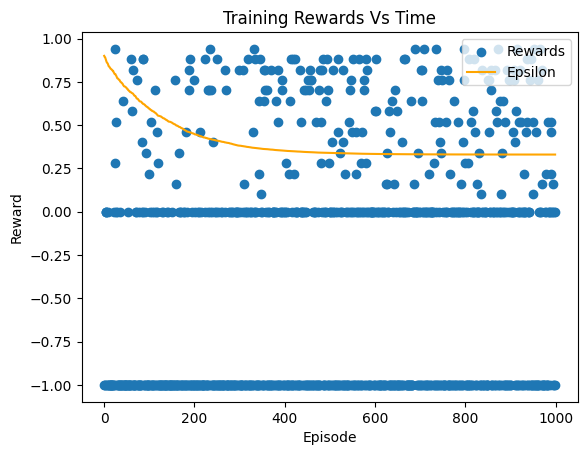

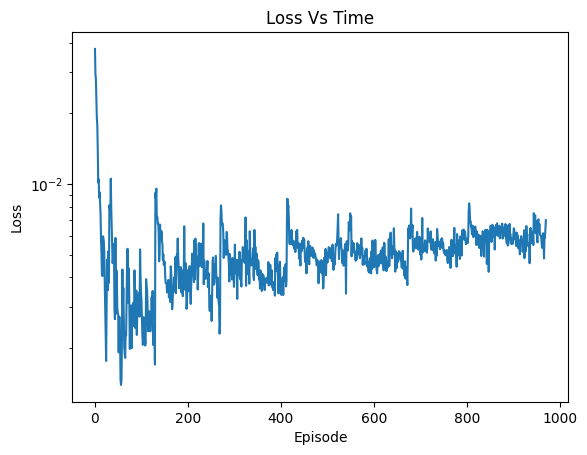

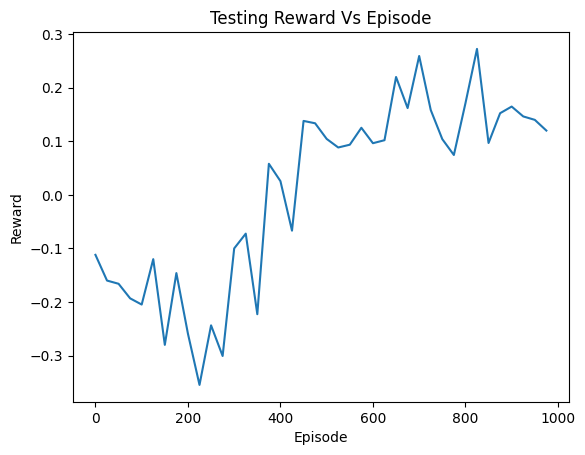

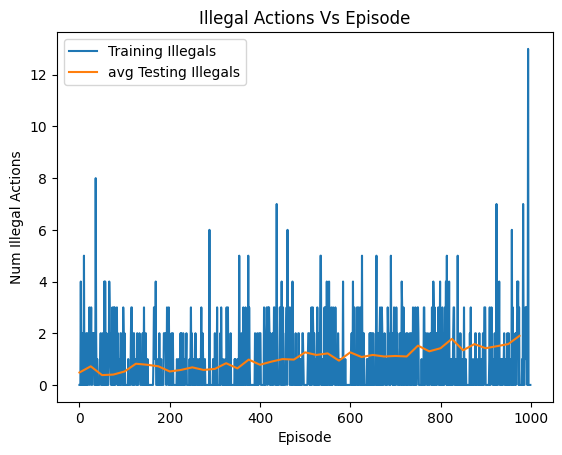

In [230]:
plt.clf()
ax = plt.gca()
plt.ticklabel_format(style="plain")
plt.title("Training Rewards Vs Time")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.scatter(range(num_episodes), episodeRewards, label="Rewards")
x, y = zip(*[[x, episodeRewards[x]] for x in range(num_episodes) if episodeRewards[x] > 0])
p = np.poly1d(np.polyfit(x, y, 1))
plt.plot(epsilons, label="Epsilon", color="orange")
plt.legend()
plt.show()
plt.clf()
plt.title("Loss Vs Time")
plt.xlabel("Episode")
plt.ylabel("Loss")
plt.yscale("log")
plt.plot([l for l in avgLosses if l != 0])
plt.show()
plt.clf()
plt.title("Testing Reward Vs Episode")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.plot([i * epsBetweenTests for i in range(int(num_episodes/epsBetweenTests))], avgTestRewards)
plt.show()
plt.title("Illegal Actions Vs Episode")
plt.xlabel("Episode")
plt.ylabel("Num Illegal Actions")
plt.plot(trainingIllegals, label="Training Illegals")
plt.plot([i * epsBetweenTests for i in range(int(num_episodes/epsBetweenTests))], testingIllegals, label="avg Testing Illegals")
plt.legend()
plt.show()



#### Observations
* A lot during training due to epsilon greedy running into random things.  
* Less during testing but slowly climbs.

#### Experiment 2: Action Masking + Thresholding DQN

In this model we now modify the code in the epsilon greedy action selection. On the greedy side we prioritize the highest non illegal action, except in the event of it being under the threshold of -1 expected reward. On the exploration side, we fully mask all illegal actions.

In [232]:
memory = ReplayMemory(MEMORY_SIZE)
policy_net = MinigridDQN(env).to(device)    #Agent Policy Net
target_net = MinigridDQN(env).to(device)    
target_net.load_state_dict(policy_net.state_dict()) #initialize the policy network weights to the target network
target_net.eval()

optimizer = optimizerType(policy_net.parameters())
 
episodeLengths = []
episodeRewards = []
allLosses = []
avgLosses = []
avgTestRewards = []
trainingIllegals = []
testingIllegals = []
epsilons = []

stepCounter = 0 #Counts the number of times we've selected actions while training
for episode in range(num_episodes):
    
    observation, _ = env.reset()
    observationTensor = observationToTensor(env, observation)
    episodeLength = 0
    episodeReward = 0
    illegalActions = 0
    episodeLosses = []
    while True:
        #Action Selection 
        epsilonThreshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * stepCounter / EPS_DECAY)
        #epsilonThreshold = EPS_END
        stepCounter += 1
        mask = ruleMask(observation, -1)
        if random.random() > epsilonThreshold:  
            with torch.no_grad():  
                action = torch.argmax(policy_net(observationTensor) * torch.tensor(mask, device=device)) #Select Best action according to policy net
        else:
            action = torch.tensor(env.action_space.sample(mask=ruleMask(observation, 0)), device=device, dtype=torch.long) #Select random action
        
        if mask[action] == -1:
            illegalActions += 1

        #Perform the action
        nextObservation, reward, terminated, truncated, _ = env.step(action.item())
        episodeReward += reward
        rewardTensor = torch.tensor(reward, device=device, dtype=torch.float)
        nextObservationTensor = None if terminated or truncated else observationToTensor(env, nextObservation)
        
        #Add the action to our memory
        memory.append(observationTensor, action, nextObservationTensor, rewardTensor)
        observationTensor = nextObservationTensor #Progress a step

        #Optimize the policy network
        if len(memory) > BATCH_SIZE: #Only perform an optimization step if we have enough memory for a batch
            transitions = memory.sample(BATCH_SIZE)
            
            # Convert list of transition tuples into a transition tuple of lists for the whole batch
            # [(o_1, no_1, ...), ..., (o_n, no_n, ...)] => ([o_1, ..., o_n], [no_1, ..., no_n], ...)
            batch = Transition(*zip(*transitions)) 

            #Mask for if the next state is a final state
            endStateMaskTuple = tuple(map(lambda s: s is not None, batch.nextObservationTensor))
            endStateMaskTensor = torch.tensor(endStateMaskTuple, device=device, dtype=torch.bool)

            #observations that aren't the end
            nonEndNextObservationTensors = torch.stack([s for s in batch.nextObservationTensor if s is not None])
            
            observationTensorBatch = torch.stack(batch.observationTensor)
            actionBatch = torch.stack(batch.action)
            rewardBatch = torch.stack(batch.reward)
            
            #predictedQs are the Q(s,a) for each state
            #policy net computes an array [Q(s, a1), Q(s, a2), ...] for all actions
            #When batched .gather(1, actionBatch) selects the Q value corresponding actual action taken 
            #  torch.gather([[Q(s1, a1), Q(s1, a2), ...],        1,  [a1, a2, ...]) = [Q(s1, a1), Q(s2, a2), ...] 
            #                [Q(s2, a1), Q(s2, a2), ...], ...],    
            predictedQs = policy_net(observationTensorBatch).gather(1, actionBatch.unsqueeze(1)).squeeze()
            
            #predictedVs are the V(s+1) = max_a(Q(s+1, a))
            predictedVs = torch.zeros(BATCH_SIZE, device=device)

            # [[Q(s1, a1), Q(s1, a2), ...],        .max(1)[0] = [max([Q(s1, a1), Q(s1, a2), ...]),
            #  [Q(s2, a1), Q(s2, a2), ...], ...],                max([Q(s2, a1), Q(s2, a2), ...]), ...]
            predictedVs[endStateMaskTensor] = target_net(nonEndNextObservationTensors).max(1)[0].detach()
            
            #The expected total reward
            expectedQs = (predictedVs * GAMMA) + rewardBatch

            #Temporal Difference Loss
            loss = lossFunc(predictedQs, expectedQs)
            episodeLosses.append(loss.item())
            allLosses.append(loss.item())

            #Back propagate on policy net
            optimizer.zero_grad()
            loss.backward()
            for param in policy_net.parameters():
                param.grad.data.clamp_(-1, 1)
            optimizer.step()
        
        #Copy our policy net to our target net
        if stepCounter % TARGET_UPDATE == 0:
            #print("Target Update")
            target_net.load_state_dict(policy_net.state_dict())

        episodeLength += 1

        #We've lost or won
        if terminated or truncated:
            #Save the stats for this run
            avgLoss = sum(episodeLosses)/len(episodeLosses) if len(episodeLosses) != 0 else 0
            avgLosses.append(avgLoss)
            if episode % printUpdateEpisodes == 0: 
                print(f"Episode: {episode}, Len:{episodeLength:>4}, Reward:{episodeReward:.2f}, Epsilon:{epsilonThreshold:.2f}, Loss:{avgLoss}")
            episodeLengths.append(episodeLength)
            episodeRewards.append(episodeReward)
            epsilons.append(epsilonThreshold)
            trainingIllegals.append(illegalActions)
            break
    
    #Run tests if we've updated the target
    if episode % epsBetweenTests == 0:
        rewards = []
        testingIllegalsList = []
        for i in range(numTestEps):
            observation, _ = env.reset()
            illegalActions = 0
            while True:
                action = torch.argmax(target_net(observationToTensor(env, observation))).cpu().item()
                if ruleMask(observation)[action] == -1:
                    illegalActions += 1
                observation, reward, terminated, truncated, info = env.step(action)
                if terminated or truncated:
                    testingIllegalsList.append(illegalActions)
                    rewards.append(reward)
                    break
        testingIllegals.append(sum(testingIllegalsList)/len(testingIllegalsList) if len(testingIllegalsList) != 0 else 0)
        avgReward = sum(rewards)/len(rewards)
        avgTestRewards.append(avgReward)
        
env.close()
torch.save(target_net.state_dict(), "trainedDQN.pt")

Episode: 0, Len:   4, Reward:0.76, Epsilon:0.90, Loss:0
Episode: 100, Len:  15, Reward:0.00, Epsilon:0.56, Loss:0.0037522005072484414
Episode: 200, Len:   9, Reward:-1.00, Epsilon:0.44, Loss:0.00444909247259299
Episode: 300, Len:   2, Reward:-1.00, Epsilon:0.38, Loss:0.008233284577727318
Episode: 400, Len:  15, Reward:0.00, Epsilon:0.35, Loss:0.005674367894728979
Episode: 500, Len:  13, Reward:-1.00, Epsilon:0.34, Loss:0.005924486125317903
Episode: 600, Len:   2, Reward:-1.00, Epsilon:0.33, Loss:0.00870775431394577
Episode: 700, Len:   8, Reward:-1.00, Epsilon:0.33, Loss:0.007622730510775
Episode: 800, Len:   8, Reward:-1.00, Epsilon:0.33, Loss:0.006902532943058759
Episode: 900, Len:   1, Reward:-1.00, Epsilon:0.33, Loss:0.008009357377886772


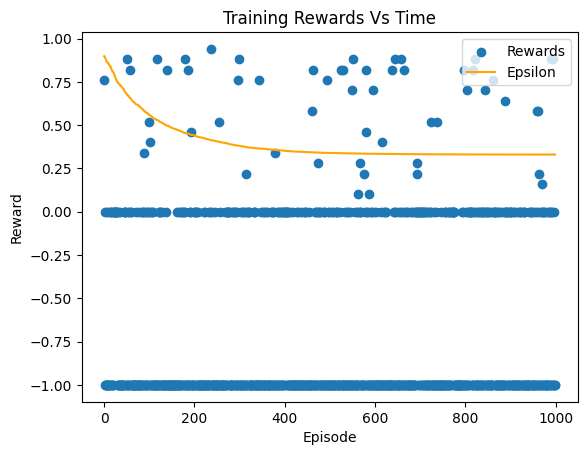

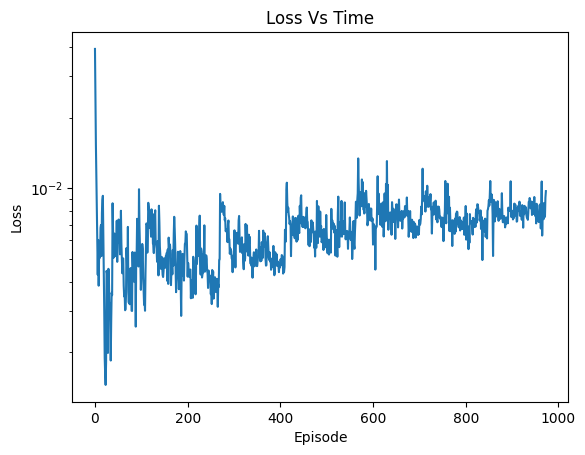

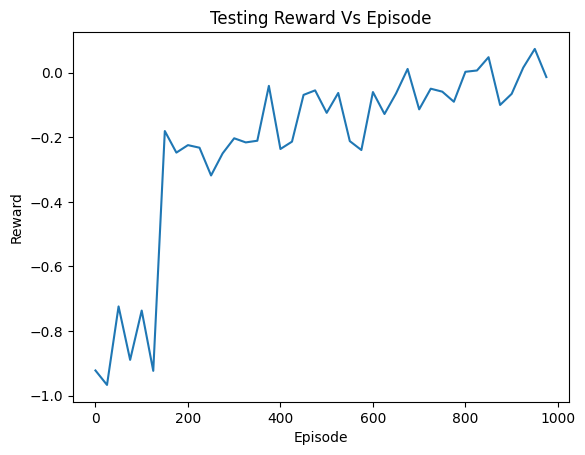

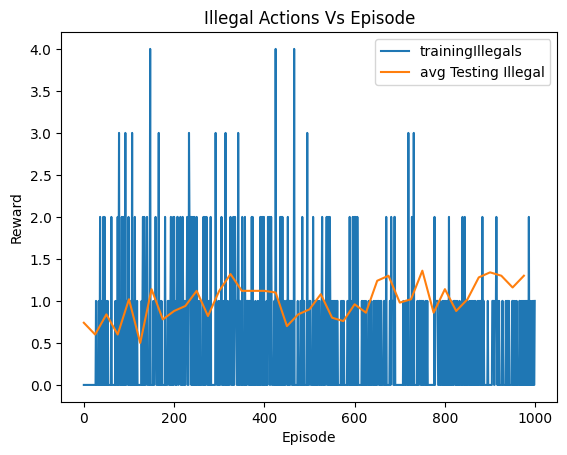

In [234]:
plt.clf()
ax = plt.gca()
plt.ticklabel_format(style="plain")
plt.title("Training Rewards Vs Time")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.scatter(range(num_episodes), episodeRewards, label="Rewards")
x, y = zip(*[[x, episodeRewards[x]] for x in range(num_episodes) if episodeRewards[x] > 0])
p = np.poly1d(np.polyfit(x, y, 1))
plt.plot(epsilons, label="Epsilon", color="orange")
plt.legend()
plt.show()
plt.clf()
plt.title("Loss Vs Time")
plt.xlabel("Episode")
plt.ylabel("Loss")
plt.yscale("log")
plt.plot([l for l in avgLosses if l != 0])
plt.show()
plt.clf()
plt.title("Testing Reward Vs Episode")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.plot([i * epsBetweenTests for i in range(int(num_episodes/epsBetweenTests))], avgTestRewards)
plt.show()
plt.title("Illegal Actions Vs Episode")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.plot(trainingIllegals, label="trainingIllegals")
plt.plot([i * epsBetweenTests for i in range(int(num_episodes/epsBetweenTests))], testingIllegals, label="avg Testing Illegal")
plt.legend()
plt.show()

##### Observations
Much less during training as the random action selection respects the mask
Halves base model’s chance of selecting an illegal action when testing.

#### Experiment 3: Penalizing for Illegal Actions with Dynamic Negative reward
If an action is illegal, penalize it with a negative -0.5 reward, on top of the other reward (running into a ball is a -1.5). This approach is more traditional, but does not guarantee alignment convergence.

In [236]:
memory = ReplayMemory(MEMORY_SIZE)
policy_net = MinigridDQN(env).to(device)    #Agent Policy Net
target_net = MinigridDQN(env).to(device)    
target_net.load_state_dict(policy_net.state_dict()) #initialize the policy network weights to the target network
target_net.eval()

optimizer = optimizerType(policy_net.parameters())
 
episodeLengths = []
episodeRewards = []
allLosses = []
avgLosses = []
avgTestRewards = []
trainingIllegals = []
testingIllegals = []
epsilons = []

stepCounter = 0 #Counts the number of times we've selected actions while training
for episode in range(num_episodes):
    
    observation, _ = env.reset()
    observationTensor = observationToTensor(env, observation)
    episodeLength = 0
    episodeReward = 0
    illegalActions = 0
    episodeLosses = []
    while True:
        #Action Selection 
        epsilonThreshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * stepCounter / EPS_DECAY)
        #epsilonThreshold = EPS_END
        stepCounter += 1
        mask = ruleMask(observation, -1)
        if random.random() > epsilonThreshold:  
            with torch.no_grad():  
                action = torch.argmax(policy_net(observationTensor)) #Select Best action according to policy net
        else:
            action = torch.tensor(env.action_space.sample(), device=device, dtype=torch.long) #Select random action
        
        if mask[action] == -1:
            illegalActions += 1

        #Perform the action
        nextObservation, reward, terminated, truncated, _ = env.step(action.item())
        if mask[action] == -1:
            reward -= 0.5
        episodeReward += reward
        rewardTensor = torch.tensor(reward, device=device, dtype=torch.float)
        nextObservationTensor = None if terminated or truncated else observationToTensor(env, nextObservation)
        
        #Add the action to our memory
        memory.append(observationTensor, action, nextObservationTensor, rewardTensor)
        observationTensor = nextObservationTensor #Progress a step

        #Optimize the policy network
        if len(memory) > BATCH_SIZE: #Only perform an optimization step if we have enough memory for a batch
            transitions = memory.sample(BATCH_SIZE)
            
            # Convert list of transition tuples into a transition tuple of lists for the whole batch
            # [(o_1, no_1, ...), ..., (o_n, no_n, ...)] => ([o_1, ..., o_n], [no_1, ..., no_n], ...)
            batch = Transition(*zip(*transitions)) 

            #Mask for if the next state is a final state
            endStateMaskTuple = tuple(map(lambda s: s is not None, batch.nextObservationTensor))
            endStateMaskTensor = torch.tensor(endStateMaskTuple, device=device, dtype=torch.bool)

            #observations that aren't the end
            nonEndNextObservationTensors = torch.stack([s for s in batch.nextObservationTensor if s is not None])
            
            observationTensorBatch = torch.stack(batch.observationTensor)
            actionBatch = torch.stack(batch.action)
            rewardBatch = torch.stack(batch.reward)
            
            #predictedQs are the Q(s,a) for each state
            #policy net computes an array [Q(s, a1), Q(s, a2), ...] for all actions
            #When batched .gather(1, actionBatch) selects the Q value corresponding actual action taken 
            #  torch.gather([[Q(s1, a1), Q(s1, a2), ...],        1,  [a1, a2, ...]) = [Q(s1, a1), Q(s2, a2), ...] 
            #                [Q(s2, a1), Q(s2, a2), ...], ...],    
            predictedQs = policy_net(observationTensorBatch).gather(1, actionBatch.unsqueeze(1)).squeeze()
            
            #predictedVs are the V(s+1) = max_a(Q(s+1, a))
            predictedVs = torch.zeros(BATCH_SIZE, device=device)

            # [[Q(s1, a1), Q(s1, a2), ...],        .max(1)[0] = [max([Q(s1, a1), Q(s1, a2), ...]),
            #  [Q(s2, a1), Q(s2, a2), ...], ...],                max([Q(s2, a1), Q(s2, a2), ...]), ...]
            predictedVs[endStateMaskTensor] = target_net(nonEndNextObservationTensors).max(1)[0].detach()
            
            #The expected total reward
            expectedQs = (predictedVs * GAMMA) + rewardBatch

            #Temporal Difference Loss
            loss = lossFunc(predictedQs, expectedQs)
            episodeLosses.append(loss.item())
            allLosses.append(loss.item())

            #Back propagate on policy net
            optimizer.zero_grad()
            loss.backward()
            for param in policy_net.parameters():
                param.grad.data.clamp_(-1, 1)
            optimizer.step()
        
        #Copy our policy net to our target net
        if stepCounter % TARGET_UPDATE == 0:
            #print("Target Update")
            target_net.load_state_dict(policy_net.state_dict())

        episodeLength += 1

        #We've lost or won
        if terminated or truncated:
            #Save the stats for this run
            avgLoss = sum(episodeLosses)/len(episodeLosses) if len(episodeLosses) != 0 else 0
            avgLosses.append(avgLoss)
            if episode % printUpdateEpisodes == 0: 
                print(f"Episode: {episode}, Len:{episodeLength:>4}, Reward:{episodeReward:.2f}, Epsilon:{epsilonThreshold:.2f}, Loss:{avgLoss}")
            episodeLengths.append(episodeLength)
            episodeRewards.append(episodeReward)
            epsilons.append(epsilonThreshold)
            trainingIllegals.append(illegalActions)
            break
    
    #Run tests if we've updated the target
    if episode % epsBetweenTests == 0:
        rewards = []
        testingIllegalsList = []
        for i in range(numTestEps):
            observation, _ = env.reset()
            illegalActions = 0
            while True:
                action = torch.argmax(target_net(observationToTensor(env, observation))).cpu().item()
                if ruleMask(observation)[action] == -1:
                    illegalActions += 1
                observation, reward, terminated, truncated, info = env.step(action)
                if terminated or truncated:
                    testingIllegalsList.append(illegalActions)
                    rewards.append(reward)
                    break
        testingIllegals.append(sum(testingIllegalsList)/len(testingIllegalsList) if len(testingIllegalsList) != 0 else 0)
        avgReward = sum(rewards)/len(rewards)
        avgTestRewards.append(avgReward)
        
env.close()
torch.save(target_net.state_dict(), "trainedDQN.pt")

Episode: 0, Len:  11, Reward:-1.00, Epsilon:0.89, Loss:0
Episode: 100, Len:   1, Reward:0.44, Epsilon:0.64, Loss:0.006514130160212517
Episode: 200, Len:  15, Reward:0.00, Epsilon:0.46, Loss:0.006139596551656723
Episode: 300, Len:  12, Reward:-1.00, Epsilon:0.38, Loss:0.005500759114511311
Episode: 400, Len:   1, Reward:-1.00, Epsilon:0.35, Loss:0.004148480016738176
Episode: 500, Len:   9, Reward:-1.50, Epsilon:0.34, Loss:0.005882598459720612
Episode: 600, Len:  15, Reward:0.00, Epsilon:0.33, Loss:0.00580721665173769
Episode: 700, Len:   5, Reward:-1.00, Epsilon:0.33, Loss:0.005717735830694437
Episode: 800, Len:   1, Reward:0.44, Epsilon:0.33, Loss:0.00817765574902296
Episode: 900, Len:  10, Reward:-1.50, Epsilon:0.33, Loss:0.006730640260502696


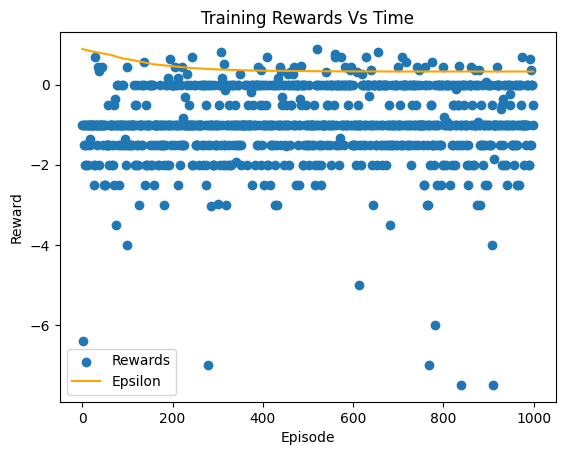

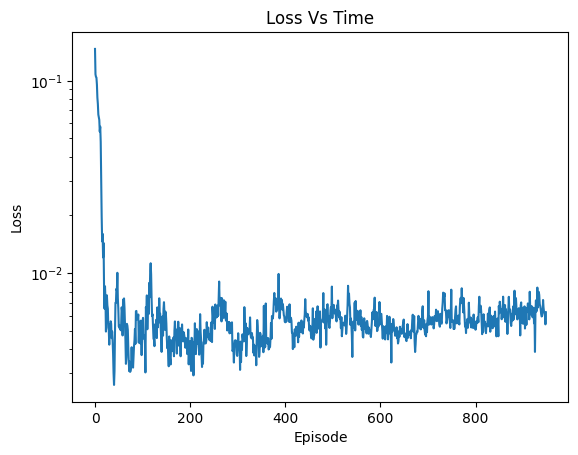

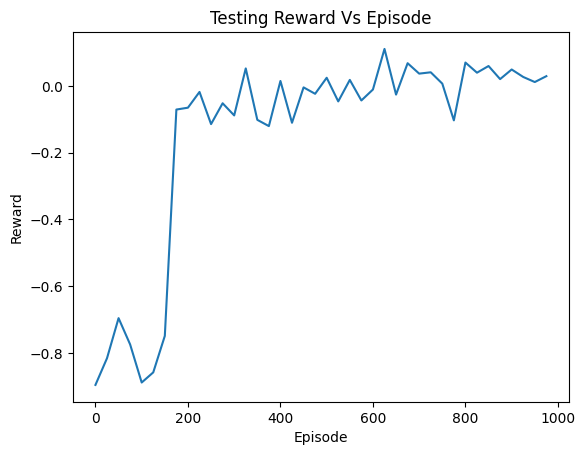

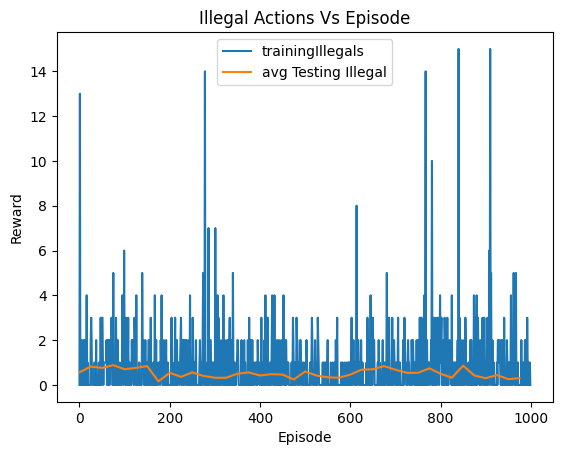

In [237]:
plt.clf()
ax = plt.gca()
plt.ticklabel_format(style="plain")
plt.title("Training Rewards Vs Time")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.scatter(range(num_episodes), episodeRewards, label="Rewards")
x, y = zip(*[[x, episodeRewards[x]] for x in range(num_episodes) if episodeRewards[x] > 0])
p = np.poly1d(np.polyfit(x, y, 1))
plt.plot(epsilons, label="Epsilon", color="orange")
plt.legend()
plt.show()
plt.clf()
plt.title("Loss Vs Time")
plt.xlabel("Episode")
plt.ylabel("Loss")
plt.yscale("log")
plt.plot([l for l in avgLosses if l != 0])
plt.show()
plt.clf()
plt.title("Testing Reward Vs Episode")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.plot([i * epsBetweenTests for i in range(int(num_episodes/epsBetweenTests))], avgTestRewards)
plt.show()
plt.title("Illegal Actions Vs Episode")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.plot(trainingIllegals, label="trainingIllegals")
plt.plot([i * epsBetweenTests for i in range(int(num_episodes/epsBetweenTests))], testingIllegals, label="avg Testing Illegal")
plt.legend()
plt.show()

##### Observations 
More illegal actions during training, but much better when testing as model is being forced to ignore them.


#### Experiment 4: Masking/Thresholding -> Penalizing illegal Actions
Any illegal action that slips past thresholding is penalized with a negative reward to prevent it in the future.

In [243]:
memory = ReplayMemory(MEMORY_SIZE)
policy_net = MinigridDQN(env).to(device)    #Agent Policy Net
target_net = MinigridDQN(env).to(device)    
target_net.load_state_dict(policy_net.state_dict()) #initialize the policy network weights to the target network
target_net.eval()

optimizer = optimizerType(policy_net.parameters())
 
episodeLengths = []
episodeRewards = []
allLosses = []
avgLosses = []
avgTestRewards = []
trainingIllegals = []
testingIllegals = []
epsilons = []

stepCounter = 0 #Counts the number of times we've selected actions while training
for episode in range(num_episodes):
    
    observation, _ = env.reset()
    observationTensor = observationToTensor(env, observation)
    episodeLength = 0
    episodeReward = 0
    illegalActions = 0
    episodeLosses = []
    while True:
        #Action Selection 
        epsilonThreshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * stepCounter / EPS_DECAY)
        #epsilonThreshold = EPS_END
        stepCounter += 1
        mask = ruleMask(observation, -1)
        if random.random() > epsilonThreshold:  
            with torch.no_grad():  
                action = torch.argmax(policy_net(observationTensor) * torch.tensor(mask, device=device)) #Select Best action according to policy net
        else:
            action = torch.tensor(env.action_space.sample(mask=ruleMask(observation, 0)), device=device, dtype=torch.long) #Select random action
        
        if mask[action] == -1:
            illegalActions += 1

        #Perform the action
        nextObservation, reward, terminated, truncated, _ = env.step(action.item())
        if mask[action] == -1:
            reward -= 0.5
        episodeReward += reward
        rewardTensor = torch.tensor(reward, device=device, dtype=torch.float)
        nextObservationTensor = None if terminated or truncated else observationToTensor(env, nextObservation)
        
        #Add the action to our memory
        memory.append(observationTensor, action, nextObservationTensor, rewardTensor)
        observationTensor = nextObservationTensor #Progress a step

        #Optimize the policy network
        if len(memory) > BATCH_SIZE: #Only perform an optimization step if we have enough memory for a batch
            transitions = memory.sample(BATCH_SIZE)
            
            # Convert list of transition tuples into a transition tuple of lists for the whole batch
            # [(o_1, no_1, ...), ..., (o_n, no_n, ...)] => ([o_1, ..., o_n], [no_1, ..., no_n], ...)
            batch = Transition(*zip(*transitions)) 

            #Mask for if the next state is a final state
            endStateMaskTuple = tuple(map(lambda s: s is not None, batch.nextObservationTensor))
            endStateMaskTensor = torch.tensor(endStateMaskTuple, device=device, dtype=torch.bool)

            #observations that aren't the end
            nonEndNextObservationTensors = torch.stack([s for s in batch.nextObservationTensor if s is not None])
            
            observationTensorBatch = torch.stack(batch.observationTensor)
            actionBatch = torch.stack(batch.action)
            rewardBatch = torch.stack(batch.reward)
            
            #predictedQs are the Q(s,a) for each state
            #policy net computes an array [Q(s, a1), Q(s, a2), ...] for all actions
            #When batched .gather(1, actionBatch) selects the Q value corresponding actual action taken 
            #  torch.gather([[Q(s1, a1), Q(s1, a2), ...],        1,  [a1, a2, ...]) = [Q(s1, a1), Q(s2, a2), ...] 
            #                [Q(s2, a1), Q(s2, a2), ...], ...],    
            predictedQs = policy_net(observationTensorBatch).gather(1, actionBatch.unsqueeze(1)).squeeze()
            
            #predictedVs are the V(s+1) = max_a(Q(s+1, a))
            predictedVs = torch.zeros(BATCH_SIZE, device=device)

            # [[Q(s1, a1), Q(s1, a2), ...],        .max(1)[0] = [max([Q(s1, a1), Q(s1, a2), ...]),
            #  [Q(s2, a1), Q(s2, a2), ...], ...],                max([Q(s2, a1), Q(s2, a2), ...]), ...]
            predictedVs[endStateMaskTensor] = target_net(nonEndNextObservationTensors).max(1)[0].detach()
            
            #The expected total reward
            expectedQs = (predictedVs * GAMMA) + rewardBatch

            #Temporal Difference Loss
            loss = lossFunc(predictedQs, expectedQs)
            episodeLosses.append(loss.item())
            allLosses.append(loss.item())

            #Back propagate on policy net
            optimizer.zero_grad()
            loss.backward()
            for param in policy_net.parameters():
                param.grad.data.clamp_(-1, 1)
            optimizer.step()
        
        #Copy our policy net to our target net
        if stepCounter % TARGET_UPDATE == 0:
            #print("Target Update")
            target_net.load_state_dict(policy_net.state_dict())

        episodeLength += 1

        #We've lost or won
        if terminated or truncated:
            #Save the stats for this run
            avgLoss = sum(episodeLosses)/len(episodeLosses) if len(episodeLosses) != 0 else 0
            avgLosses.append(avgLoss)
            if episode % printUpdateEpisodes == 0: 
                print(f"Episode: {episode}, Len:{episodeLength:>4}, Reward:{episodeReward:.2f}, Epsilon:{epsilonThreshold:.2f}, Loss:{avgLoss}")
            episodeLengths.append(episodeLength)
            episodeRewards.append(episodeReward)
            epsilons.append(epsilonThreshold)
            trainingIllegals.append(illegalActions)
            break
    
    #Run tests if we've updated the target
    if episode % epsBetweenTests == 0:
        rewards = []
        testingIllegalsList = []
        for i in range(numTestEps):
            observation, _ = env.reset()
            illegalActions = 0
            while True:
                action = torch.argmax(target_net(observationToTensor(env, observation))).cpu().item()
                if ruleMask(observation)[action] == -1:
                    illegalActions += 1
                observation, reward, terminated, truncated, info = env.step(action)
                if terminated or truncated:
                    testingIllegalsList.append(illegalActions)
                    rewards.append(reward)
                    break
        testingIllegals.append(sum(testingIllegalsList)/len(testingIllegalsList) if len(testingIllegalsList) != 0 else 0)
        avgReward = sum(rewards)/len(rewards)
        avgTestRewards.append(avgReward)
        
env.close()
torch.save(target_net.state_dict(), "trainedDQN.pt")

Episode: 0, Len:  15, Reward:0.00, Epsilon:0.89, Loss:0
Episode: 100, Len:  14, Reward:-1.00, Epsilon:0.60, Loss:0.0029622269129114492
Episode: 200, Len:   6, Reward:-1.00, Epsilon:0.45, Loss:0.0020729336150301
Episode: 300, Len:   2, Reward:-1.50, Epsilon:0.39, Loss:0.0010662924614734948
Episode: 400, Len:   4, Reward:-2.00, Epsilon:0.36, Loss:0.003260423196479678
Episode: 500, Len:  15, Reward:0.00, Epsilon:0.34, Loss:0.00225631035088251
Episode: 600, Len:   4, Reward:-1.00, Epsilon:0.33, Loss:0.004456541675608605
Episode: 700, Len:   4, Reward:-1.50, Epsilon:0.33, Loss:0.0029916962375864387
Episode: 800, Len:   3, Reward:-1.00, Epsilon:0.33, Loss:0.0029864882429440818
Episode: 900, Len:  15, Reward:0.00, Epsilon:0.33, Loss:0.0041380655330916245


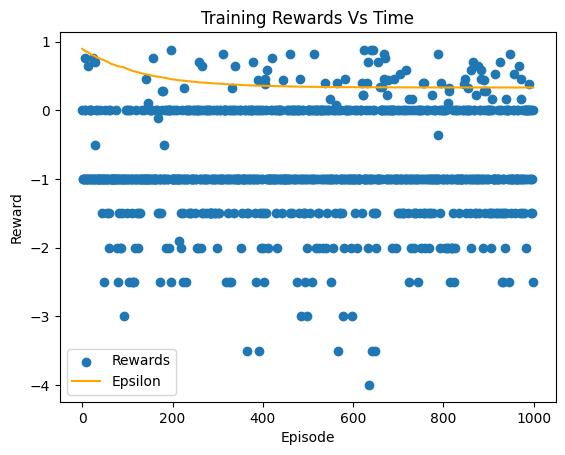

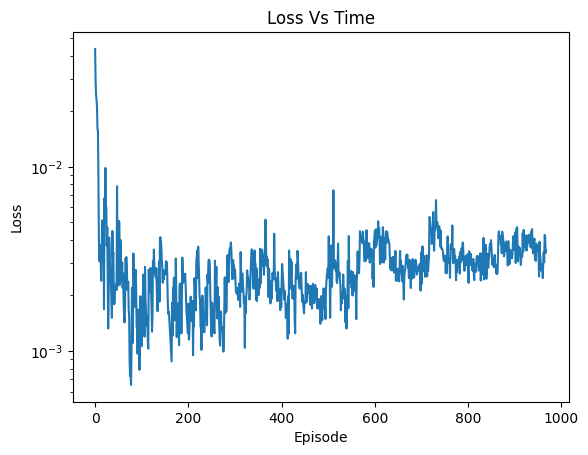

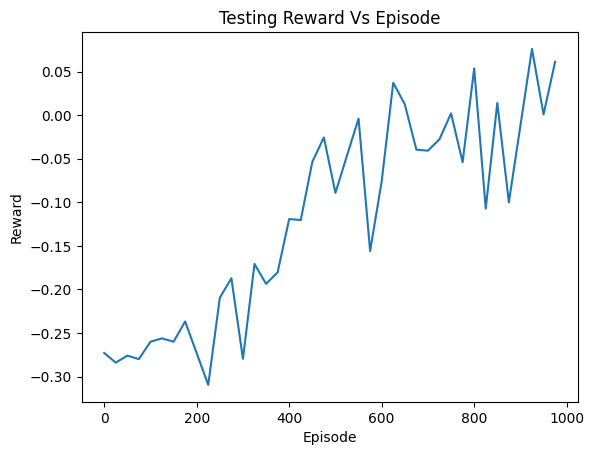

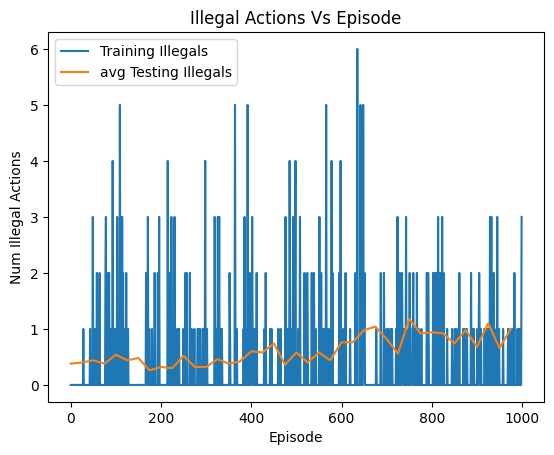

In [246]:
plt.clf()
ax = plt.gca()
plt.ticklabel_format(style="plain")
plt.title("Training Rewards Vs Time")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.scatter(range(num_episodes), episodeRewards, label="Rewards")
x, y = zip(*[[x, episodeRewards[x]] for x in range(num_episodes) if episodeRewards[x] > 0])
p = np.poly1d(np.polyfit(x, y, 1))
plt.plot(epsilons, label="Epsilon", color="orange")
plt.legend()
plt.show()
plt.clf()
plt.title("Loss Vs Time")
plt.xlabel("Episode")
plt.ylabel("Loss")
plt.yscale("log")
plt.plot([l for l in avgLosses if l != 0])
plt.show()
plt.clf()
plt.title("Testing Reward Vs Episode")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.plot([i * epsBetweenTests for i in range(int(num_episodes/epsBetweenTests))], avgTestRewards)
plt.show()
plt.title("Illegal Actions Vs Episode")
plt.xlabel("Episode")
plt.ylabel("Num Illegal Actions")
plt.plot(trainingIllegals, label="Training Illegals")
plt.plot([i * epsBetweenTests for i in range(int(num_episodes/epsBetweenTests))], testingIllegals, label="avg Testing Illegals")
plt.legend()
plt.show()


##### Observations
* More illegal actions while training.
* Lowest on average so far when testing but rising by the end. 

### Conclusions

We present a summarized view of the aggregated data from the tables above for all our experiments:

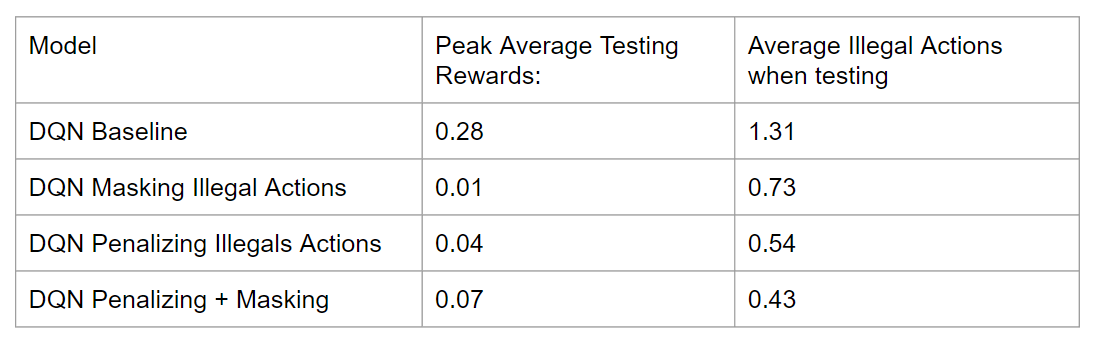

In [253]:
from IPython.display import Image
Image(filename='Results.png')

The results clearly that both masking and penalizing will reduce illegal actions in this environment, greatly helping with illegal action alignment, getting it down to about half what the baseline had. Unfortunately we see that in this environment we selected with these constraints/rules, It was unfeasible to get better reward performance. One hypothesis is that the agent could have been using some of the illegal actions for things like a null move that worked to its benefit. Another is that as we removed actions from being played during training, the training data looses some diversity making out of sample situations more likely to occur. We see in the table that our combined Masking/Thresholding into piping approach has the best balance as having both the fewest illegal actions performed but also the best rewards of all three.   